<a href="https://colab.research.google.com/github/afloresblas/BigDataProject/blob/main/ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Big Data - Ray

In [1]:
# Dataset
# https://www.kaggle.com/rikdifos/credit-card-approval-prediction?select=credit_record.csv

# Tecnologias para el procesamiento
# 1. Ray
# Por presentar:
# Introducción / Avance 50% (Ingesta + EDA)
# IMPORTANTE: Usar %Time

# Imports

In [2]:
!pip install --user --ignore-installed funcsigs
!pip install ray 

     |████████████████████████████████| 57.6 MB 1.7 kB/s 
     |████████████████████████████████| 119 kB 34.2 MB/s 


In [3]:
import pandas as pd
import ray
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Entidades , Variables, Constantes

# Carga de Datos

In [4]:
# Mounting del drive con la data

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Ray

In [5]:
# Inicialización de Ray
ray.init(num_cpus=4, ignore_reinit_error=True)

{'metrics_export_port': 63998,
 'node_id': '26296f3f9eec43773fa1bb2a0739d689feb0f0a7bf27a5c245c33479',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-12-14_02-50-09_709811_62/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-12-14_02-50-09_709811_62/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-12-14_02-50-09_709811_62',
 'webui_url': None}

In [75]:
# Carga de datos - Funcion optimizada con Ray
%time
@ray.remote
def read_application():
  application_df = pd.read_csv('/content/gdrive/MyDrive/BigData/Proyecto/archive/application_record.csv')
  return application_df

@ray.remote
def read_credit():
  credit_df = pd.read_csv('/content/gdrive/MyDrive/BigData/Proyecto/archive/credit_record.csv')
  return credit_df

application_df = read_application.remote()
credit_df = read_credit.remote()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [7]:
%time
ray.get(application_df).head()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.5 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [8]:
%time
ray.get(credit_df).head()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.54 µs


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# Pre - Procesamiento (Limpieza)

In [9]:
# Análisis de valores duplicados
## Id's únicos dentro del dataframe df_application
%time
print("Cantidad de registros dentro de df_data:", ray.get(application_df).shape[0])
print("Cantidad de id's únicos dentro de df_data", ray.get(credit_df)['ID'].nunique())
## NO coincide la cantidad de registros únicos con la cantidad de registros dentro
## del dataframe

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs
Cantidad de registros dentro de df_data: 438557
Cantidad de id's únicos dentro de df_data 45985


In [10]:
## Los valores duplicados dentro del dataset serán eliminados

%time
@ray.remote
def drop_id_duplicates(df):
  return df.drop_duplicates('ID', keep = 'last')

application_df = drop_id_duplicates.remote(application_df)

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 10.5 µs


In [11]:
## Id's únicos dentro del dataframe df_record
%time
print("Cantidad de registros dentro de df_record:",ray.get(credit_df).shape[0])
print("Cantidad de id's únicos dentro de df_record",ray.get(credit_df)['ID'].nunique())
# NO coincide la cantidad de registros únicos con la cantidad de registros dentro
# porque son datos mensuales

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 19.6 µs
Cantidad de registros dentro de df_record: 1048575
Cantidad de id's únicos dentro de df_record 45985


In [12]:
## Número de id's que las dos tables comparten
%time
print(len(set(ray.get(application_df)["ID"]).intersection(set(ray.get(credit_df)["ID"]))))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs
36457


In [13]:
# Análisis de valores nulos df_application
%time
print("-----------Análisis de valores nulos df_application-------------------")
print(ray.get(application_df).isnull().sum())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
-----------Análisis de valores nulos df_application-------------------
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134187
CNT_FAM_MEMBERS             0
dtype: int64


In [14]:
# El campo OCCUPATION_TYPE tiene gran cantidad de valores nulos
# no se tomará en cuenta este campo por dicha razón
ray.get(application_df).drop('OCCUPATION_TYPE', axis=1, inplace=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


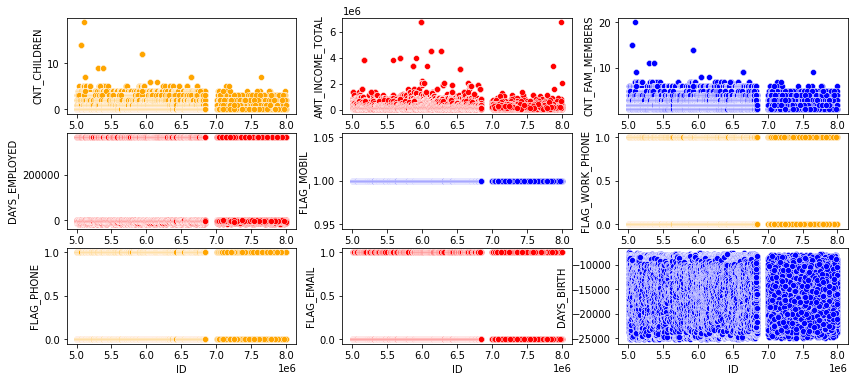

In [76]:
## Se halla que existen outliers en las columnas CNT_CHILDREN, AMT_INCOME_TOTAL y CNT_FAM_MEMBERS
%time
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=ray.get(application_df), ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=ray.get(application_df), ax=ax[0][1], color='red')
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=ray.get(application_df), ax=ax[0][2], color='blue')
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=ray.get(application_df), ax=ax[1][0], color='red')
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=ray.get(application_df), ax=ax[1][1], color='blue')
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=ray.get(application_df), ax=ax[1][2], color='orange')
sns.scatterplot(x='ID', y='FLAG_PHONE', data=ray.get(application_df), ax=ax[2][0], color='orange')
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=ray.get(application_df), ax=ax[2][1], color='red')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=ray.get(application_df), ax=ax[2][2], color= 'blue')

In [77]:
%time
#Depuración de outliers para el campo 'CNT_FAM_MEMBERS'
limite_superior = ray.get(application_df)['CNT_FAM_MEMBERS'].quantile(0.999)
limite_inferior = ray.get(application_df)['CNT_FAM_MEMBERS'].quantile(0.001)
df_application = ray.get(application_df)[(ray.get(application_df)['CNT_FAM_MEMBERS']<limite_superior) & (ray.get(application_df)['CNT_FAM_MEMBERS']>limite_inferior)]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs


In [78]:
%time
#Depuración de outliers para el campo 'AMT_INCOME_TOTAL'
limite_superior = ray.get(application_df)['AMT_INCOME_TOTAL'].quantile(0.999)
limite_inferior = ray.get(application_df)['AMT_INCOME_TOTAL'].quantile(0.001)
df_application = ray.get(application_df)[(ray.get(application_df)['AMT_INCOME_TOTAL']<limite_superior) & (ray.get(application_df)['AMT_INCOME_TOTAL']>limite_inferior)]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


In [79]:
%time
#Depuración de outliers para el campo 'CNT_CHILDREN'
limite_superior = ray.get(application_df)['CNT_CHILDREN'].quantile(0.999)
limite_inferior = ray.get(application_df)['CNT_CHILDREN'].quantile(0.001)
df_application = ray.get(application_df)[(ray.get(application_df)['CNT_CHILDREN']<limite_superior) & (ray.get(application_df)['CNT_CHILDREN']>limite_inferior)]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


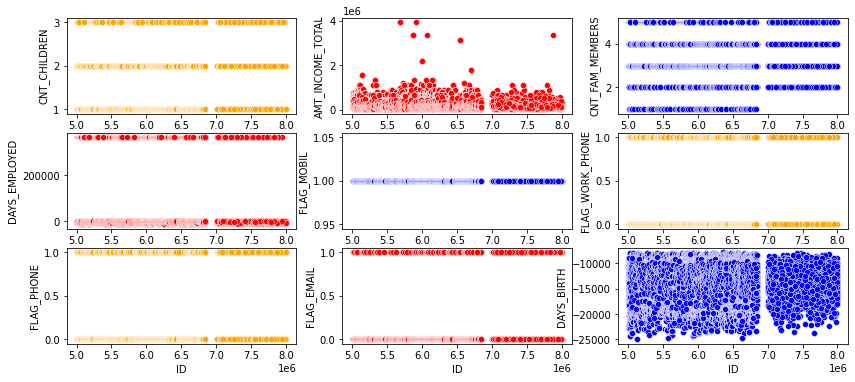

In [80]:
## Verificación de eliminación de outliers 'CNT_CHILDREN, AMT_INCOME_TOTAL y CNT_FAM_MEMBERS
%time
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=df_application, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=df_application, ax=ax[0][1], color='red')
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=df_application, ax=ax[0][2], color='blue')
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=df_application, ax=ax[1][0], color='red')
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=df_application, ax=ax[1][1], color='blue')
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=df_application, ax=ax[1][2], color='orange')
sns.scatterplot(x='ID', y='FLAG_PHONE', data=df_application, ax=ax[2][0], color='orange')
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=df_application, ax=ax[2][1], color='red')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=df_application, ax=ax[2][2], color= 'blue')

In [81]:
%time
## Dado que las dos tablas se deberán unir y el campo status del 
## df_record es lo que se debe predecir, se debe codificar
df_record = ray.get(credit_df)
df_record['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
df_record['STATUS'] = df_record['STATUS'].astype('int')
df_record['STATUS'] = df_record['STATUS'].apply(lambda x:1 if x >= 2 else 0)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


In [82]:
%time
## Se observa que los datos nos stán balanceados
df_record['STATUS'].value_counts(normalize=True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


0    0.99704
1    0.00296
Name: STATUS, dtype: float64

In [83]:
# Unificación de las dos tablas
df_record = df_record.groupby('ID').agg(max).reset_index()
%time
#union = pd.merge(df_application, df_record, on="ID")
union = df_application.join(df_record.set_index('ID'), on='ID', how='inner')
union.drop(['MONTHS_BALANCE'], axis=1, inplace=True)
union.info()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11167 entries, 24 to 434805
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   11167 non-null  int64  
 1   CODE_GENDER          11167 non-null  object 
 2   FLAG_OWN_CAR         11167 non-null  object 
 3   FLAG_OWN_REALTY      11167 non-null  object 
 4   CNT_CHILDREN         11167 non-null  int64  
 5   AMT_INCOME_TOTAL     11167 non-null  float64
 6   NAME_INCOME_TYPE     11167 non-null  object 
 7   NAME_EDUCATION_TYPE  11167 non-null  object 
 8   NAME_FAMILY_STATUS   11167 non-null  object 
 9   NAME_HOUSING_TYPE    11167 non-null  object 
 10  DAYS_BIRTH           11167 non-null  int64  
 11  DAYS_EMPLOYED        11167 non-null  int64  
 12  FLAG_MOBIL           11167 non-null  int64  
 13  FLAG_WORK_PHONE      11167 non-null  int64  
 14  FLAG_PHONE          

In [84]:
%time
union.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10 µs


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
24,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2.0,0
25,5008835,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2.0,0
27,5008836,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,-12689,-1163,1,0,0,0,Laborers,5.0,0
28,5008837,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,-12689,-1163,1,0,0,0,Laborers,5.0,0
29,5008838,M,N,Y,1,405000.0,Commercial associate,Higher education,Married,House / apartment,-11842,-2016,1,0,0,0,Managers,3.0,0


In [85]:
%time
# Eliminación de columnas que no se usarán para el análisis
union.drop(columns=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], inplace=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs
El 54.8% no tiene un vehículo


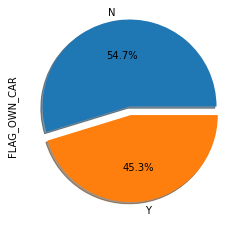

In [86]:
%time
print("El 54.8% no tiene un vehículo")
union['FLAG_OWN_CAR'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs
Del total el 61.3% son mujeres


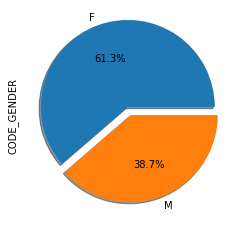

In [87]:
%time
print("Del total el 61.3% son mujeres")
union['CODE_GENDER'].value_counts().plot(kind='pie', explode=(0.1,0), shadow=True, autopct='%1.1f%%')

In [88]:
%time
print("La mayoría tiene 1 hijo")
union['CNT_CHILDREN'].value_counts()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
La mayoría tiene 1 hijo


1    7492
2    3256
3     419
Name: CNT_CHILDREN, dtype: int64

In [89]:
%time
print("La mayoría de usuarios tiene tres familiares")
union['CNT_FAM_MEMBERS'].value_counts()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
La mayoría de usuarios tiene tres familiares


3.0    6421
4.0    3106
2.0    1241
5.0     391
1.0       8
Name: CNT_FAM_MEMBERS, dtype: int64

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


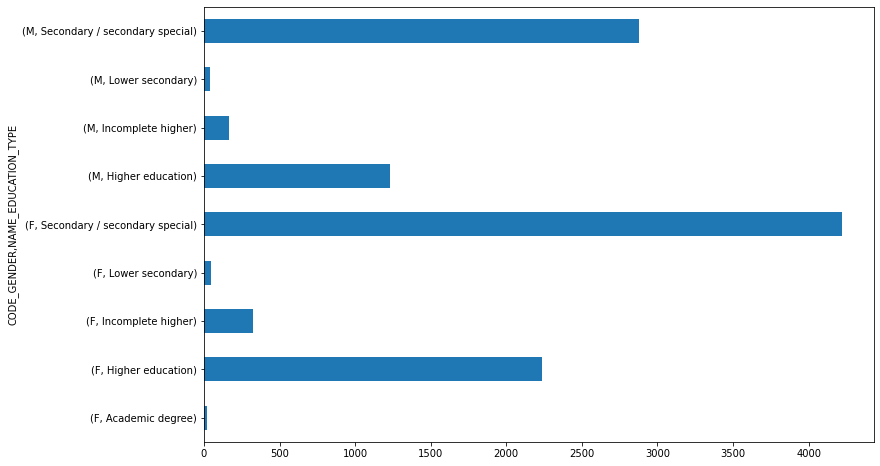

In [90]:
%time
union.groupby(['CODE_GENDER', 'NAME_EDUCATION_TYPE']).size().plot(kind='barh', figsize = (12, 8))

In [91]:
## Cast de datos y eliminación de filas que contengan valores nulos
%time
df_union = union.dropna()

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 27.9 µs


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs
Las familias que tienen tres hijos son las que mayor ingreso perciben


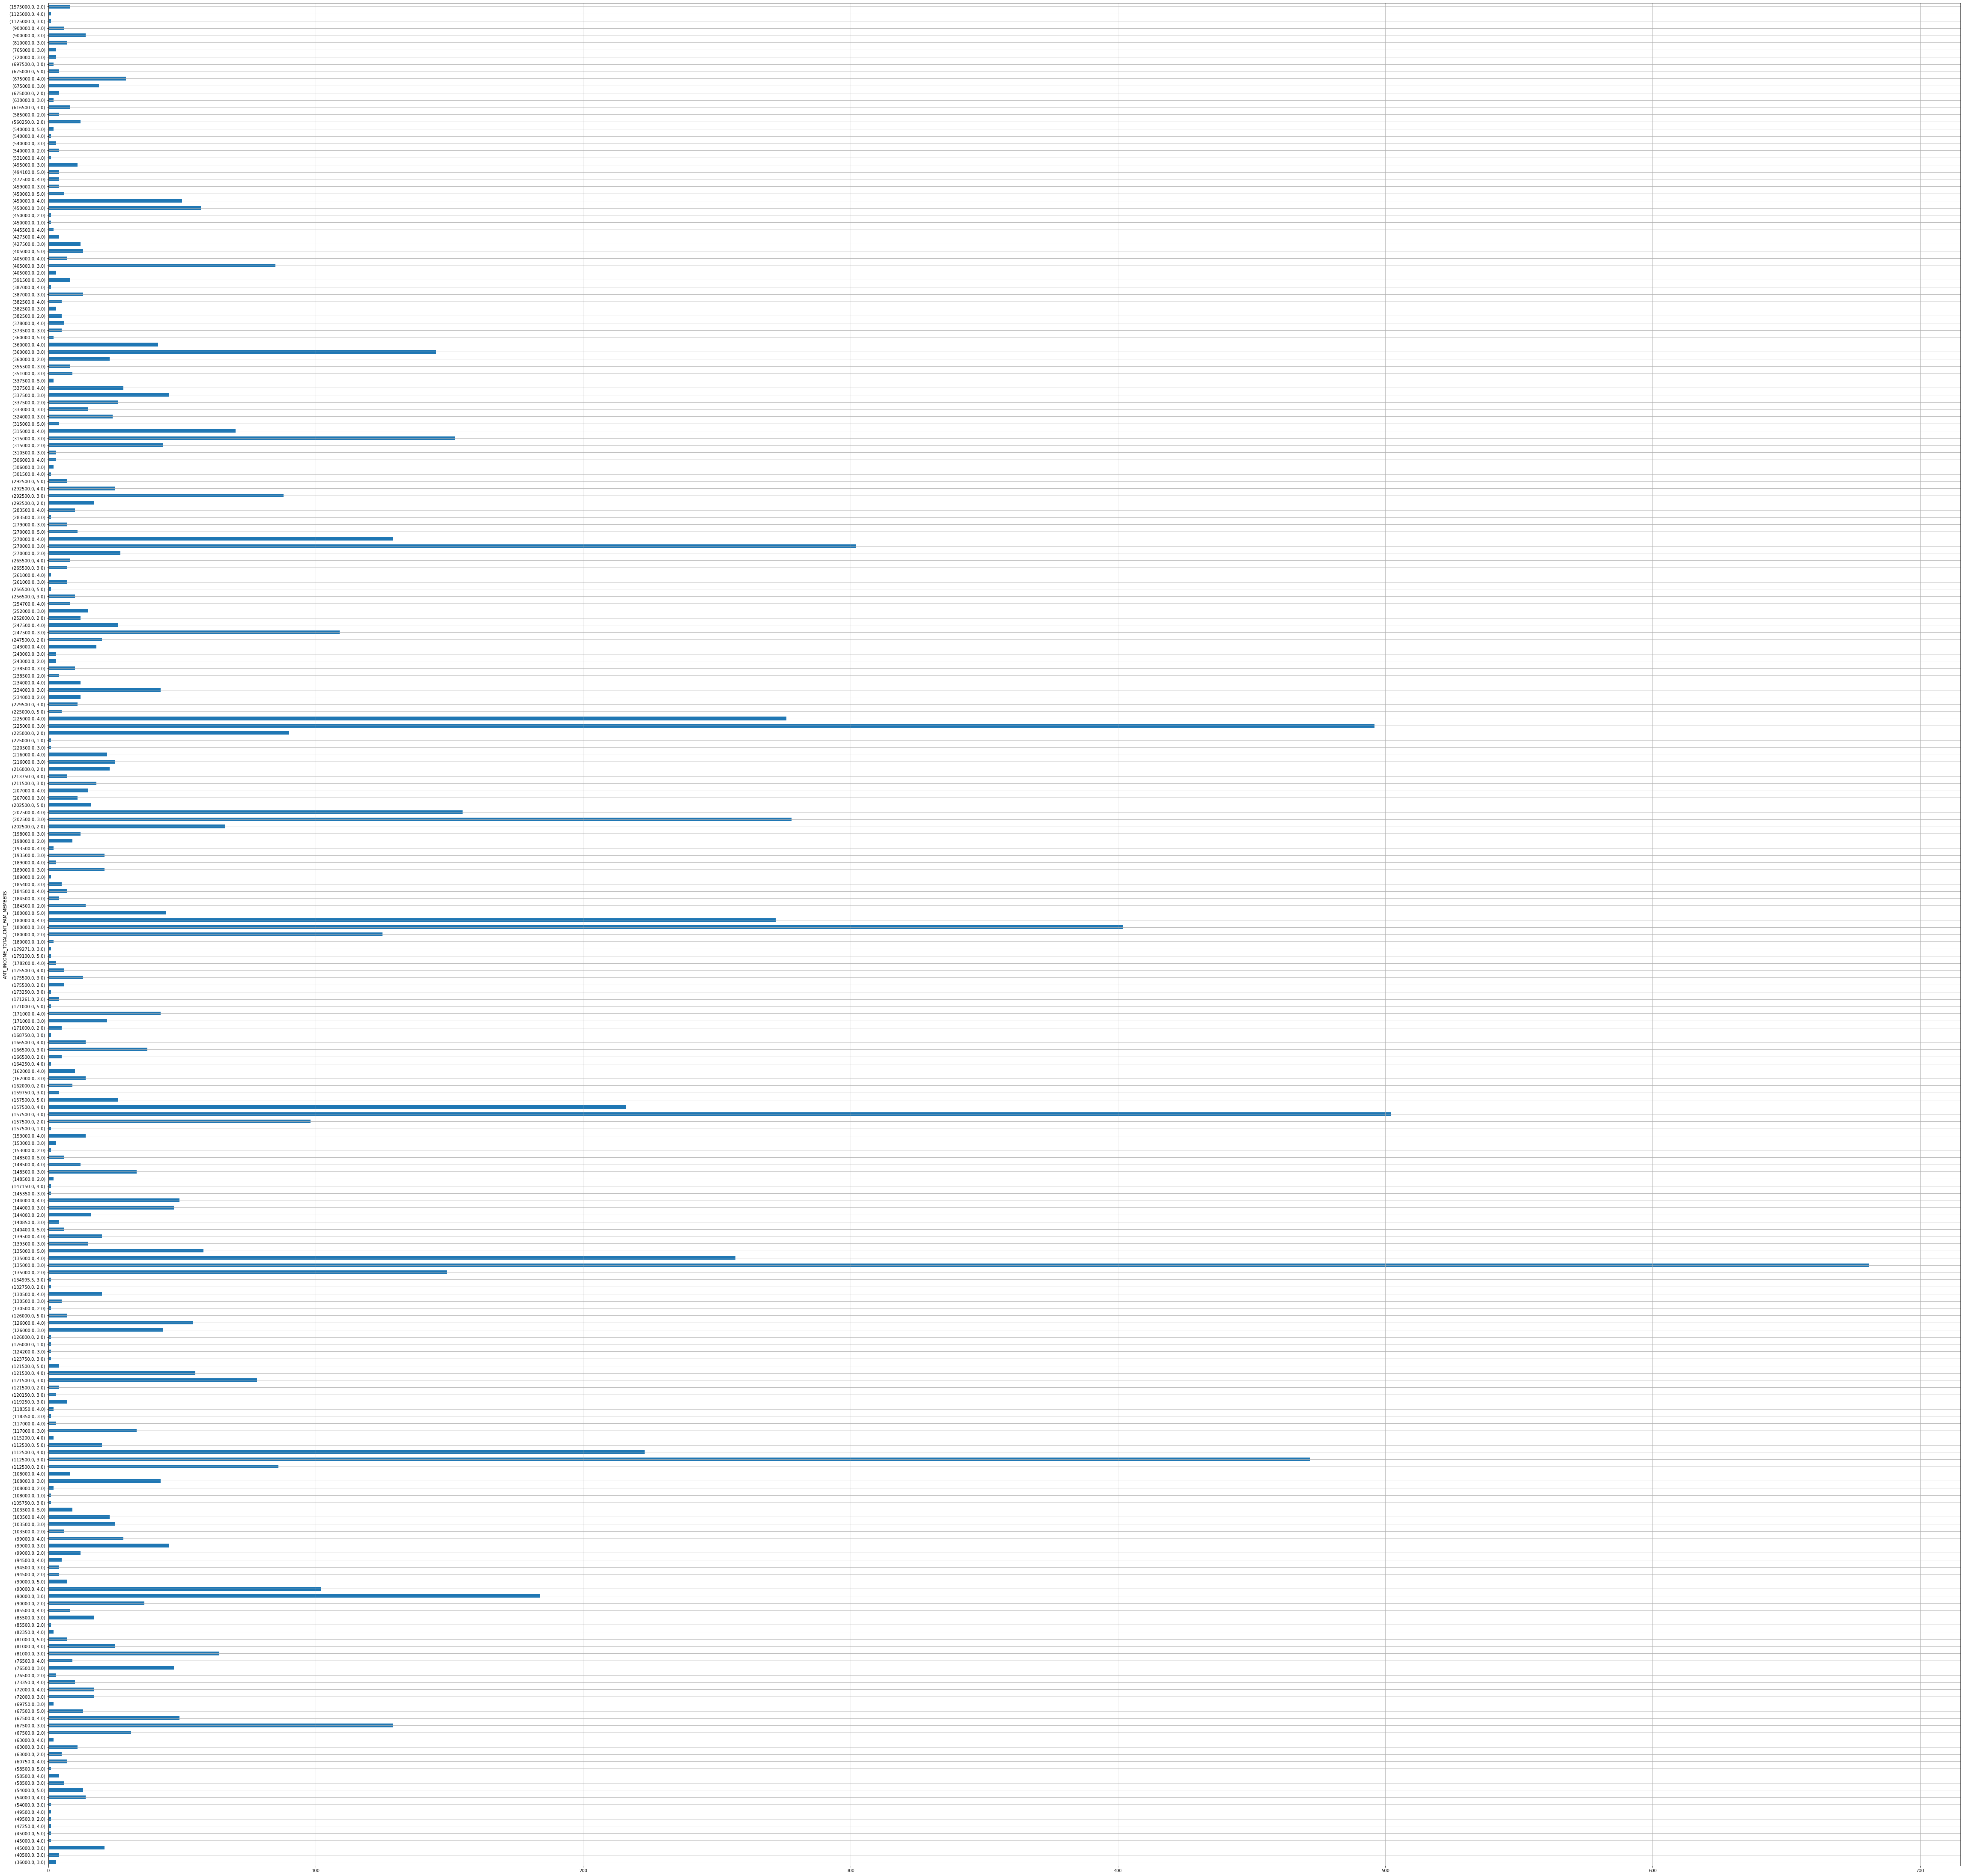

In [92]:
%time
print("Las familias que tienen tres hijos son las que mayor ingreso perciben")
df_union.groupby(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']).size().plot(kind='barh', figsize=(80, 80), grid=True)